The data was sampled from Crossref database in February-May 2019. Collected only meta-information on papers with abstracts published in scientific journals without limits by date of publishing.

In [1]:
%matplotlib inline
import crossref_analysis as cross
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

paper_collection = paper_collection = "papers_crossref.txt"
data = cross.readBigCollection(paper_collection)
data['journal-name'] = data['journal-name'].apply(lambda x: x.lower().replace(' and ', ' & ').replace(':', '').replace(',', '').replace('.', '').replace('the ', '').strip())
data.head()

,assertion,author,content-domain,funder,issue,issued,journal-name,license,number-of-authors,page,published-online,published-print,publisher,referenced,references-count,short-journal-name,subject,title,type,volume
0,NaN,"[{'given': 'Richard N.', 'family': 'Hiscott', ...","{'domain': [], 'crossmark-restriction': False}",NaN,02,1996,quaternary research,[{'URL': 'http://www.elsevier.com/tdm/userlice...,2.0,160-175,2017.0,1996.0,Cambridge University Press (CUP),24,41,[Quat. res.],NaN,Quaternary Sedimentary Processes and Budgets i...,journal-article,45
1,NaN,"[{'given': 'Edgar Sebastián', 'family': 'Villa...","{'domain': [], 'crossmark-restriction': False}",NaN,4,2013,animal production science,NaN,5.0,360,NaN,2013.0,CSIRO Publishing,0,28,[Anim. Prod. Sci.],NaN,What do domestic livestock eat in northern Pat...,journal-article,53
2,NaN,"[{'given': 'Teng', 'family': 'Sun', 'sequence'...","{'domain': [], 'crossmark-restriction': False}",NaN,4,2013,journal of rheumatology,NaN,8.0,493-497,2013.0,2013.0,The Journal of Rheumatology,12,23,[J Rheumatol],NaN,Coronary Artery Involvement in Takayasu Arteri...,journal-article,40
3,NaN,"[{'given': 'Tao', 'family': 'Chen', 'sequence'...","{'domain': ['www.aabacteria.org'], 'crossmark-...",NaN,1s,2013,acetic acid bacteria,NaN,5.0,6,2013.0,NaN,PAGEPress Publications,17,0,[Acetic Acid Bacteria],NaN,Analysis of variation of main components durin...,journal-article,2
4,NaN,"[{'given': 'Seung Ju', 'family': 'Han', 'seque...","{'domain': [], 'crossmark-restriction': False}",NaN,NaN,2013,advanced materials research,NaN,2.0,34-37,2013.0,NaN,Trans Tech Publications,2,5,[AMR],NaN,Flexural Toughness of Sprayable Strain-Hardeni...,journal-article,658


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [3]:
data.describe()

,issued,number-of-authors,published-online,published-print,referenced,references-count
count,2.231022e+06,2.220251e+06,1.650208e+06,1.028603e+06,2.231022e+06,2.231022e+06
mean,2.009186e+03,3.349690e+00,2.013572e+03,2.003757e+03,4.587224e+00,1.619131e+01
std,1.551902e+01,2.767826e+00,7.197577e+00,2.013319e+01,4.749635e+01,2.751937e+01
min,1.770000e+03,1.000000e+00,1.852000e+03,1.770000e+03,0.000000e+00,0.000000e+00
25%,2.009000e+03,1.000000e+00,2.012000e+03,1.999000e+03,0.000000e+00,0.000000e+00
50%,2.014000e+03,3.000000e+00,2.016000e+03,2.011000e+03,0.000000e+00,4.000000e+00
75%,2.017000e+03,4.000000e+00,2.018000e+03,2.015000e+03,3.000000e+00,2.500000e+01
max,2.019000e+03,4.980000e+02,2.019000e+03,2.019000e+03,5.858100e+04,1.637000e+03


In [66]:
def strip_string(string):
    return string.strip()

exp_q = r' \(Q\d+\)'
journals_rating = pd.read_csv('scimagojr_2016.csv', sep=';', low_memory=False)
journals_rating['Title'] = journals_rating['Title'].apply(lambda x: x.lower().replace(' and ', ' & ').replace(':', '').replace(' of the united states of america', '').replace('the ', '').replace(',', '').replace('.', '').strip())
journals_rating.set_index('Title', inplace=True)
journals_rating['Categories'] = journals_rating['Categories'].str.replace(exp_q, '')

categs = journals_rating['Categories'].str.get_dummies(sep=';')
categs.columns = map(strip_string, categs.columns)
categs = categs.T.reset_index().groupby('index').sum().T
cond = categs.sum() >= 200
used_categories = np.array(cond[cond].index) # categories of science wich will used in model
categs = categs[used_categories]
journals_rating = journals_rating.join(categs)
journals_rating.head()

,Rank,Sourceid,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2016),Total Docs. (3years),Total Refs.,...,Signal Processing,Social Psychology,Social Sciences (miscellaneous),Sociology and Political Science,Software,Statistics and Probability,Strategy and Management,Surgery,Visual Arts and Performing Arts,Water Science and Technology
Title,,,,,,,,,,,,,,,,,,,,,
10th acm international conference on underwater networks & systems wuwnet 2015,28461,21100456776,conference and proceedings,00002015,"0,105",-,5,0,47,0,...,0,0,0,0,1,0,0,0,0,0
10th aiaa multidisciplinary design optimization specialist conference,16978,21100286949,conference and proceedings,00002014,"0,214",-,5,0,37,0,...,0,0,0,0,1,0,0,0,0,0
10th annual international systems conference syscon 2016 - proceedings,32289,21100469383,conference and proceedings,00002016,NaN,-,6,159,0,2980,...,0,0,0,0,0,0,0,0,0,0
10th european workshop on microelectronics education ewme 2014,30012,21100332235,conference and proceedings,00002014,"0,101",-,3,0,47,0,...,0,0,0,0,0,0,0,0,0,0
10th fpgaworld conference - academic proceedings 2013 fpgaworld 2013,24217,21100262309,conference and proceedings,00002013,"0,125",-,3,0,12,0,...,0,0,0,0,0,0,0,0,0,0


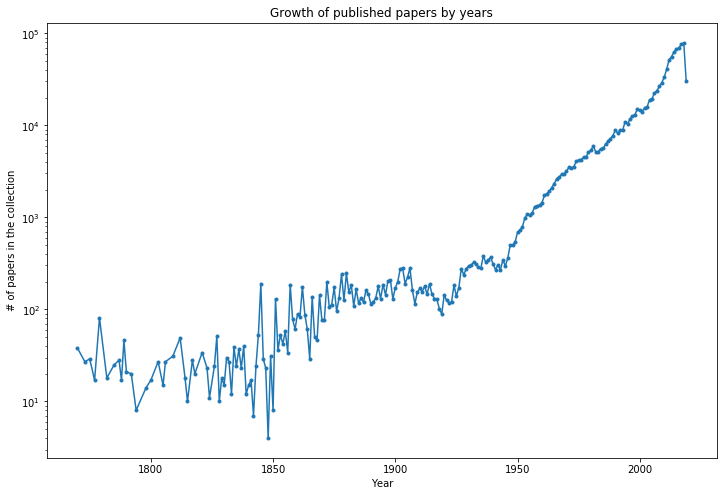

In [67]:
grouped_by_year = data.groupby('published-print').agg(['count', 'median', 'mean', 'sum'])

plt.figure(figsize=(12,8))
plt.plot(grouped_by_year.index, grouped_by_year['issued']['count'], '.-')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('# of papers in the collection')
plt.title('Growth of published papers by years')
plt.show()

The dataset includes 2.23 mln papers published in scientific journals from 1770 to 2019. Number of papers in the Crossreff database has low rate of growth before 1950 when it reach not more than half of thousand. From the second half of twenty sentury rate of growth increased significantly. It has slight slowdown шт 1980-th and in last years.

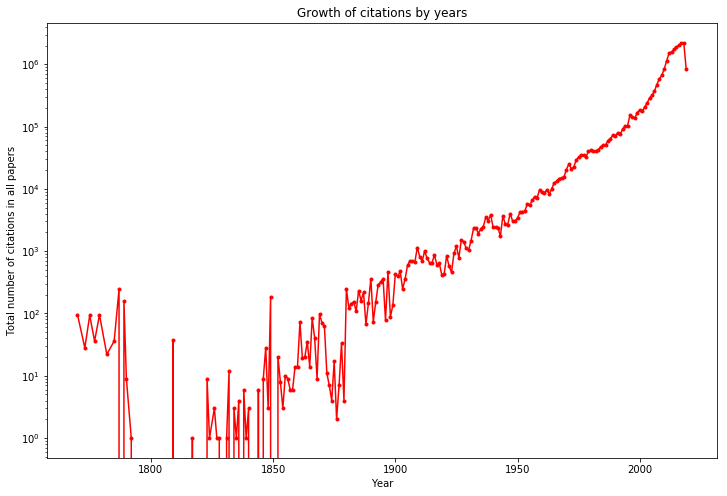

In [68]:
plt.figure(figsize=(12,8))
plt.plot(grouped_by_year.index, grouped_by_year['references-count']['sum'], '.-', color='red')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Total number of citations in all papers')
plt.title('Growth of citations by years')
plt.show()

Total number of citations per year has a logarithm growth from 100 before 1900 to the more than million after 2000. In the first years of 21 sentury the rate of growth was increased, but it significantly decreased in last years.

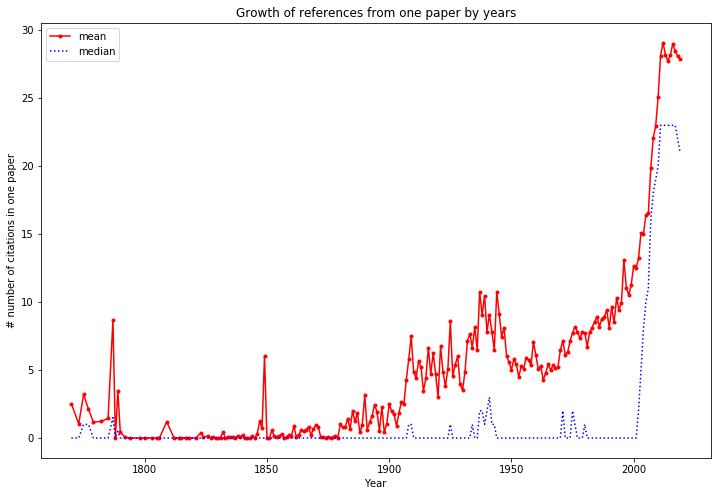

In [69]:
plt.figure(figsize=(12,8))
plt.plot(grouped_by_year.index, grouped_by_year['references-count']['mean'], '.-', color='red', label = 'mean')
plt.plot(grouped_by_year.index, grouped_by_year['references-count']['median'], ':', color='blue', label = 'median')
plt.xlabel('Year')
plt.ylabel('# number of citations in one paper')
plt.title('Growth of references from one paper by years')
plt.legend(loc=0)
plt.show()

Before 1950 mean number of citations in one paper were mainly below 10. The significant groth of citations number in one paper starts from 1980-th. The very high rate of increased this number was observed from 2000. Now, the number reaches its maximum close to 30 citations per paper.

So, increasing total number of references is due increasing number of published papers as well as groth of average number of citations in paper. 

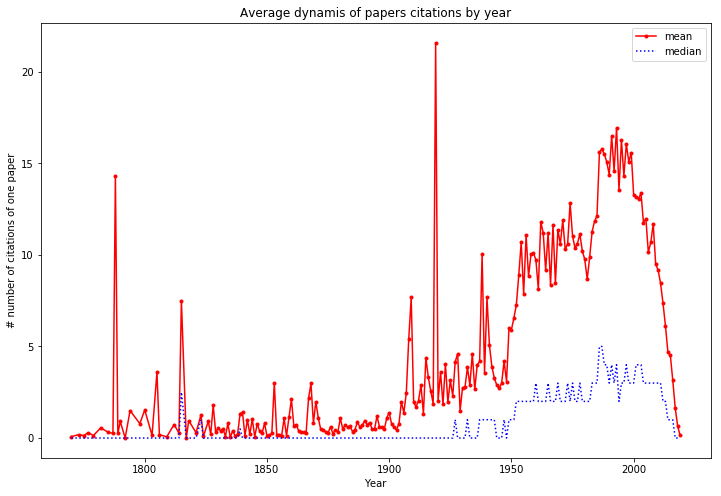

In [70]:
plt.figure(figsize=(12,8))
plt.plot(grouped_by_year.index, grouped_by_year['referenced']['mean'], '.-', color='red', label = 'mean')
plt.plot(grouped_by_year.index, grouped_by_year['referenced']['median'], ':', color='blue', label = 'median')
plt.xlabel('Year')
plt.ylabel('# number of citations of one paper')
plt.title('Average dynamis of papers citations by year')
plt.legend(loc=0)
plt.show()

Average number of citations of paper has a clear tendency to growth from 1900. Difference between mean and median number of paper citations increases in these years. The difference is due to the relative small portion of papers got large part of citations, but most of papers got not more than five citations.

Any paper need some time to reach high number of citations. Mean number of citations reach maximum in 1990th. However, median value reaches maximum later, in 2000th. So, most papers need no more than 10 years for collect most of them citations, but most popular for citing papers collect references 30 and more years.

Further we will analyze only recently published papers because we need short-term result for fast growth of scientific authority and career. Papers published in 2016 will analyzed because 3 year is a term for preparing Ph.D. thesis. Young scientist usually wan't wait more than three years after publising his/her main first publications for the next stage of career growth.

In [71]:
# Remove rows with journals which couldn't finded in file with journal ratings (and categories)
data2016 = data[data['published-print'] == 2016]
data2016 = data2016.join(journals_rating, lsuffix='_l', on='journal-name')
data2016_cleared = data2016.dropna(subset=['H index'])
data2016_noHirsh = data2016[data2016['H index'].isnull()]
print('Number of articles with unknown journals - {}'.format(data2016_noHirsh.shape[0]))
data2016_noHirsh_grouped = data2016_noHirsh.groupby('journal-name').agg('count')
print('Number of unknown journals - {}'.format(data2016_noHirsh_grouped.shape[0]))
data2016_noHirsh_grouped.head()
data2016_noHirsh_grouped.to_csv('unknown_journals.csv')

Number of articles with unknown journals - 20887
Number of unknown journals - 1215


In [72]:
data2016_cleared.isnull().sum()

assertion                                                42537
author                                                      43
content-domain                                               0
funder                                                   38138
issue                                                    12235
issued                                                       0
journal-name                                                 0
license                                                  24108
number-of-authors                                           43
page                                                      7555
published-online                                         27826
published-print                                              0
publisher                                                    0
referenced                                                   0
references-count                                             0
short-journal-name                                     

In [73]:
td = data2016_cleared.groupby('journal-name').agg('median')
td.sort_values(by='referenced', inplace=True, ascending=False)

#data2016['H index'] = data2016['H index'].astype('float')
td[['referenced']].head(10)

,referenced
journal-name,
science,66.0
science translational medicine,36.0
clinical microbiology reviews,33.0
microbiology & molecular biology reviews,25.5
annals of rheumatic diseases,23.5
acta numerica,21.0
journal of experimental medicine,20.0
science advances,19.5
proceedings of national academy of sciences,19.0


In [74]:
data2016_cleared.to_csv('papers_crossref_2016.csv')

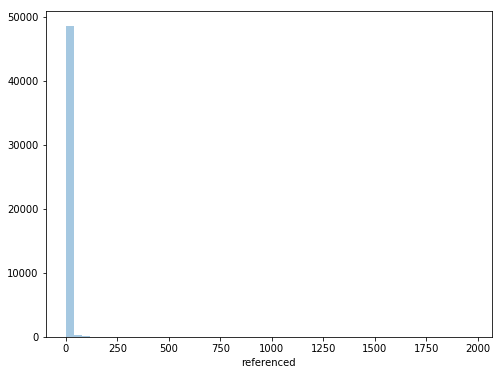

In [75]:
plt.figure(figsize=(8,6))
sns.distplot(a=data2016_cleared['referenced'], kde=False)
plt.show()

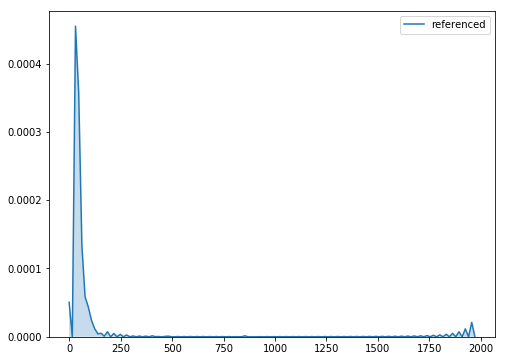

In [76]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=data2016_cleared['referenced'], shade=True)
plt.show()

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


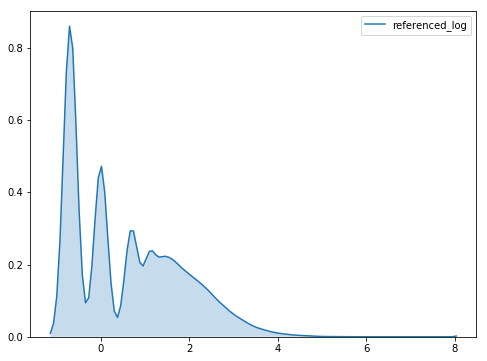

In [77]:
templog = data2016_cleared['referenced'].fillna(0.5)
templog[templog < 0.5] = 0.5
data2016_cleared['referenced_log'] = np.log(templog)
plt.figure(figsize=(8,6))
sns.kdeplot(data=data2016_cleared['referenced_log'], shade=True)

Total number of papers published in scientific journals in 2016 is 69469 items in the dataset. Mean number of citations is 3.14, but half of the papers has not more than one citation. First quartile is 0; its mean that not less than 25% of papers have no references. However, not less than 25% of papers has 3 and more citations. Maximum number of citations for papers published in 2016 is 1971 now.

In [78]:
data2016_cleared.sort_values(by='referenced', inplace=True, ascending=False)
data2016_cleared[['referenced', 'title', 'journal-name']].head(10)
#st = data[:1]['journal-name']
#print(st)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,referenced,title,journal-name
1912234,1971,The Cambridge Structural Database,acta crystallographica section b structural sc...
456399,851,A vacuum flash–assisted solution process for h...,science
800150,477,Zika Virus,clinical microbiology reviews
2164853,411,Four billion people facing severe water scarcity,science advances
1899237,285,Fundamentals of cancer metabolism,science advances
653025,247,In vivo aspects of protein folding and quality...,science
104473,226,"Taxonomy, Physiology, and Natural Products of ...",microbiology & molecular biology reviews
1716770,224,Ultraflexible organic photonic skin,science advances
1267510,215,Acoustic metamaterials: From local resonances ...,science advances
657010,199,Zika Virus: New Clinical Syndromes and Its Eme...,journal of virology


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


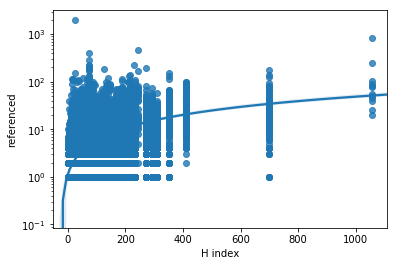

In [79]:
import seaborn as sns
data2016_cleared['H index'] = data2016_cleared['H index'].astype('float')

sns.regplot(x=data2016_cleared['H index'], y=data2016_cleared['referenced'])
plt.yscale('log')

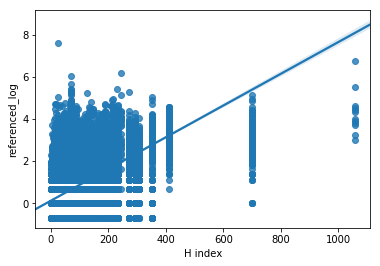

In [80]:
sns.regplot(x=data2016_cleared['H index'], y=data2016_cleared['referenced_log'])

In [81]:
correlations = data2016_cleared.corr()['referenced']
correlations[abs(correlations) > 0.1]

number-of-authors           0.167056
referenced                  1.000000
references-count            0.216042
Rank                       -0.215799
H index                     0.285412
Total Docs. (2016)          0.121113
Total Refs.                 0.161455
Total Cites (3years)        0.179753
Medicine (miscellaneous)    0.103057
referenced_log              0.495689
Name: referenced, dtype: float64

In [107]:
X = np.array(data2016_cleared['H index']).reshape(-1, 1)
Y = np.array(data2016_cleared['referenced']) #.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
Y_l = np.array(data2016_cleared['referenced_log']) #.reshape(-1, 1)

model0 = LinearRegression()
model0.fit(X_train, y_train)
print(model0.intercept_, model0.coef_)
print("Linear regression R2 on train {}".format(model0.score(X_train, y_train)))
print("Linear regression R2 on test {}".format(model0.score(X_test, y_test)))
Y_pred = model0.predict(X_test)
print("Среднеквадратичная ошибка оценки {}".format(metrics.mean_squared_error(y_test, Y_pred)))

1.145607975321615 [0.04783888]
Linear regression R2 on train 0.07326975388409462
Linear regression R2 on test 0.15379767182405835
Среднеквадратичная ошибка оценки 75.57786941251867


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_l, test_size=0.2, random_state=5)
model0_log = LinearRegression()
model0_log.fit(X_train, y_train)
print(model0_log.intercept_, model0_log.coef_)
print("Linear regression R2 on train {}".format(model0_log.score(X_train, y_train)))
print("Linear regression R2 on test {}".format(model0_log.score(X_test, y_test)))
Y_pred = model0_log.predict(X_test)
print("Среднеквадратичная ошибка оценки {}".format(metrics.mean_squared_error(y_test, Y_pred)))

0.1178468497849059 [0.00748618]
Linear regression R2 on train 0.24158549851641387
Linear regression R2 on test 0.24203828993592946
Среднеквадратичная ошибка оценки 1.137130618924046


In [111]:
xs = used_categories.copy()
#xs.append('H index')
xs = np.append(xs, 'H index')
X = data2016_cleared[xs]
X['H index'] = preprocessing.scale(np.array(X['H index']).reshape(-1, 1))
Y = np.array(data2016_cleared['referenced'])
#Y_l = np.array(data2016_cleared['referenced_log']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

model1 = LinearRegression()
model1.fit(X_train, y_train)
#print(model1.intercept_, model1.coef_)
print("Linear regression R2 on train {}".format(model1.score(X_train, y_train)))
print("Linear regression R2 on test {}".format(model1.score(X_test, y_test)))
Y_pred = model1.predict(X_test)
print("Среднеквадратичная ошибка оценки {}".format(metrics.mean_squared_error(y_test, Y_pred)))

Linear regression R2 on train 0.09313435140931015
Linear regression R2 on test 0.13899661280963926
Среднеквадратичная ошибка оценки 82.66654622026343


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [112]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=200, min_samples_split=5, n_jobs=4,random_state=7)
model_rf.fit(X_train, y_train)
Y_pred = model_rf.predict(X_test)
print("Среднеквадратичная ошибка оценки {}".format(metrics.mean_squared_error(y_test, Y_pred)))

Среднеквадратичная ошибка оценки 76.91421322305054
